In [1]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr, mannwhitneyu
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

H = pickle.load( open('../January-23/data/G_ALL.p', 'rb'))
MAPty = pickle.load(open('../January-23/data/MAPty.p', 'rb'))
MAPgn = pickle.load(open('../January-23/data/MAPgn.p', 'rb'))
MAPcl = pickle.load(open('../January-23/data/MAPcl.p', 'rb'))

BEDPRO = pd.read_table('../June-23/BEDPRO_new.tsv')
N = pd.read_table('../data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
print(BEDPRO.shape, N.shape)

sns.set(style="ticks", font_scale=2)

def flatten(l):
    return [item for sublist in l for item in sublist]


(13452, 19) (78245, 30)


In [2]:

rna = np.log(BEDPRO[['Gene', 'Vh', '30m', '4h', '16h', '72h']].set_index('Gene')+1).to_dict('index')

#P = [k for k, v in MAPty.items() if v == 'Promoter']
P = [k for k, v in MAPcl.items() if v == 'ANDR']


CI = []
EX = []
for p in P:
    if p not in H:
        continue
    neig = list(H.neighbors(p))
    if len(neig) < 1:
        continue


    for e in neig: 
        
        w = H.get_edge_data(p, e)
        CI.append([p,e, MAPgn[p], MAPcl[e]] + list(w.values()) )
    
    EX.append([p,e] + list(rna[MAPgn[p]].values()) )

        

CI = pd.DataFrame(CI, columns=['Promoter', 'Enhancer', 'Gene', 'Set'] + list(w.keys()))

EX = pd.DataFrame(EX, columns=['Promoter', 'Enhancer', 'Exp_Vh', 'Exp_30m', 'Exp_4h' ,'Exp_16h', 'Exp_72h'])


In [3]:

DOM = {}

for i, t in enumerate(['Vh','30m','4h','16h','72h']):
		
	ci = CI[['Set', 'Enhancer', 'Promoter','Gene',f'H3K27ac.{t}']].set_index([ 'Gene', 'Promoter', 'Set', 'Enhancer']).groupby('Gene').transform(lambda x: (x - x.min()) / (x.max()- x.min()))
	ci[f'H3K4me3.{t}'] = CI[['Set', 'Enhancer', 'Promoter','Gene',f'H3K4me3.{t}']].set_index([ 'Gene', 'Promoter', 'Set', 'Enhancer']).groupby('Gene').transform(lambda x: (x - x.min()) / (x.max()- x.min()))[f'H3K4me3.{t}']

	#data = ci[(ci[f'H3K27ac.{t}'] > 0.9) | (ci[f'H3K4me3.{t}'] > 0.9)].reset_index()

	ci = ci.reset_index()

	for j,row in ci.iterrows():
		
		d = str(np.abs(int(row['Promoter'].split('-')[-1]) - int(row['Enhancer'].split('-')[-1])))
		name = row['Gene'] +','+ row['Promoter'] +','+ row['Enhancer'] +','+ row['Set'] +','+ d
		if name not in DOM:
			DOM[name] = [0]*5


		if (row[f'H3K27ac.{t}'] > 0.9) or (row[f'H3K4me3.{t}'] > 0.9):
			DOM[name][i] += 1
	


In [4]:
data = pd.DataFrame.from_dict(DOM, 'index', columns=['0m','30m','4h','16h','72h']).reset_index()
tmp = data['index'].str.split(',', expand=True)

data['Gene'] = tmp[0]
data['Promoter'] = tmp[1]
data['Contact'] = tmp[2]
data['Set'] = tmp[3]
data['Distance'] = tmp[4]

data = data[['Gene', 'Promoter','Contact','Set','Distance', '0m','30m','4h','16h','72h']] 

data.loc[data['Set'] != 'ARcre', 'Set'] = 'cre'

data['Enhancer'] = data['Contact']
data['Dom'] = (data[['0m','30m','4h','16h', '72h']].sum(1) != 0).astype(int)
data

,Gene,Promoter,Contact,Set,Distance,0m,30m,4h,16h,72h,Enhancer,Dom
0,GNAI3,chr1:110088733-110093733,chr1:109966562-109971562,cre,122171,0,0,0,0,0,chr1:109966562-109971562,0
1,GNAI3,chr1:110088733-110093733,chr1:110034221-110039221,cre,54512,0,0,0,0,0,chr1:110034221-110039221,0
2,GNAI3,chr1:110088733-110093733,chr1:110103387-110108387,cre,14654,1,1,1,1,1,chr1:110103387-110108387,1
3,GNAI3,chr1:110088733-110093733,chr1:110159959-110164959,cre,71226,1,0,0,1,1,chr1:110159959-110164959,1
4,GNAI3,chr1:110088733-110093733,chr1:110172872-110177872,ARcre,84139,0,0,0,0,0,chr1:110172872-110177872,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,SAT1,chrX:23798790-23803790,chrX:23917919-23922919,cre,119129,1,1,1,1,1,chrX:23917919-23922919,1
1639,SAT1,chrX:23798790-23803790,chrX:23935573-23940573,cre,136783,0,0,0,0,0,chrX:23935573-23940573,0
1640,SAT1,chrX:23798790-23803790,chrX:24042803-24047803,cre,244013,0,0,0,0,0,chrX:24042803-24047803,0
1641,SAT1,chrX:23798790-23803790,chrX:24070333-24075333,cre,271543,0,0,0,0,0,chrX:24070333-24075333,0


In [5]:
cik = CI[['Set', 'Enhancer', 'Promoter','Gene','H3K27ac.Vh','H3K27ac.30m','H3K27ac.4h','H3K27ac.16h','H3K27ac.72h']].set_index(['Set', 'Enhancer', 'Promoter', 'Gene']).stack().reset_index().groupby(['Gene', 'Enhancer']).std().rename(columns={0:'H3K27ac.SD'})
cik['H3K4me3.SD'] = CI[['Set', 'Enhancer', 'Promoter','Gene','H3K4me3.Vh','H3K4me3.30m','H3K4me3.4h','H3K4me3.16h','H3K4me3.72h']].set_index(['Set', 'Enhancer', 'Promoter', 'Gene']).stack().reset_index().groupby(['Gene', 'Enhancer']).std()[0]


cik = cik.reset_index()
cik['Name'] = cik['Gene'] +','+ cik['Enhancer']

cik

,Gene,Enhancer,H3K27ac.SD,H3K4me3.SD,Name
0,ABCC4,chr13:95778309-95783309,0.209016,0.429798,"ABCC4,chr13:95778309-95783309"
1,ABCC4,chr13:95830928-95835928,0.248548,0.959056,"ABCC4,chr13:95830928-95835928"
2,ABCC4,chr13:95842259-95847259,0.352777,0.918324,"ABCC4,chr13:95842259-95847259"
3,ABCC4,chr13:95863342-95868342,1.593877,1.397407,"ABCC4,chr13:95863342-95868342"
4,ABCC4,chr13:95896501-95901501,0.952184,0.756197,"ABCC4,chr13:95896501-95901501"
...,...,...,...,...,...
1638,ZMIZ1,chr10:80852779-80857779,0.961086,0.243758,"ZMIZ1,chr10:80852779-80857779"
1639,ZMIZ1,chr10:80862564-80867564,0.542524,0.939308,"ZMIZ1,chr10:80862564-80867564"
1640,ZMIZ1,chr10:80914845-80919845,0.722249,0.340666,"ZMIZ1,chr10:80914845-80919845"
1641,ZMIZ1,chr10:80952678-80957678,1.026576,0.667510,"ZMIZ1,chr10:80952678-80957678"


In [6]:
data['H3K27ac.SD'] = (data['Gene'] +','+ data['Contact']).map(dict(zip(cik['Name'], np.log(cik['H3K27ac.SD']+1))))
data['H3K4me3.SD'] = (data['Gene'] +','+ data['Contact']).map(dict(zip(cik['Name'], np.log(cik['H3K4me3.SD']+1))))
#data.to_csv('../data/TABLE/DOM_Kinetic.tsv', index=False, sep='\t')
data


,Gene,Promoter,Contact,Set,Distance,0m,30m,4h,16h,72h,Enhancer,Dom,H3K27ac.SD,H3K4me3.SD
0,GNAI3,chr1:110088733-110093733,chr1:109966562-109971562,cre,122171,0,0,0,0,0,chr1:109966562-109971562,0,0.456151,0.600613
1,GNAI3,chr1:110088733-110093733,chr1:110034221-110039221,cre,54512,0,0,0,0,0,chr1:110034221-110039221,0,0.564482,0.940398
2,GNAI3,chr1:110088733-110093733,chr1:110103387-110108387,cre,14654,1,1,1,1,1,chr1:110103387-110108387,1,1.554920,1.331253
3,GNAI3,chr1:110088733-110093733,chr1:110159959-110164959,cre,71226,1,0,0,1,1,chr1:110159959-110164959,1,0.626291,1.443669
4,GNAI3,chr1:110088733-110093733,chr1:110172872-110177872,ARcre,84139,0,0,0,0,0,chr1:110172872-110177872,0,0.683662,0.744099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,SAT1,chrX:23798790-23803790,chrX:23917919-23922919,cre,119129,1,1,1,1,1,chrX:23917919-23922919,1,0.977768,1.234624
1639,SAT1,chrX:23798790-23803790,chrX:23935573-23940573,cre,136783,0,0,0,0,0,chrX:23935573-23940573,0,0.344115,0.431703
1640,SAT1,chrX:23798790-23803790,chrX:24042803-24047803,cre,244013,0,0,0,0,0,chrX:24042803-24047803,0,0.497195,0.532502
1641,SAT1,chrX:23798790-23803790,chrX:24070333-24075333,cre,271543,0,0,0,0,0,chrX:24070333-24075333,0,0.738903,0.723201


(-0.18943152604197847, 4.4)

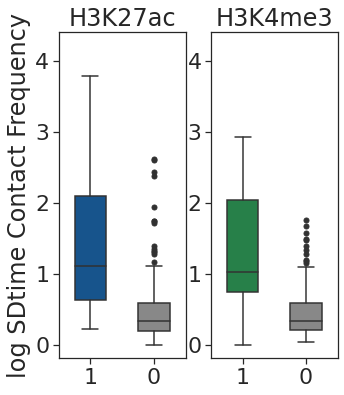

In [7]:


fig = plt.figure(figsize=[5,6])
gs = gridspec.GridSpec(nrows=1, ncols=2)

fig.add_subplot(gs[0])
tmp = data[data['Set'] == 'ARcre']
tmp = tmp.set_index(['Set', 'H3K27ac.SD'])[['0m','30m','4h','16h','72h']].stack().reset_index()
sns.boxplot(data=tmp[tmp['level_2'] == '16h'],y='H3K27ac.SD',x=0, palette=['#04559F', '#888888'], order=[1, 0], width=0.5, flierprops={'marker':'o'})
#sns.violinplot(data=tmp, x='level_2',y='H3K27ac.SD',hue=0, split=True,palette=['#888888', '#04559F'])
plt.xlabel('')
plt.ylabel('log SDtime Contact Frequency')
plt.legend([],frameon=False)
plt.title('H3K27ac')
ylim = plt.gca().get_ylim()
plt.ylim(ylim[0], 4.4)


fig.add_subplot(gs[1])
tmp = data[data['Set'] == 'ARcre']
tmp = tmp.set_index(['Set', 'H3K4me3.SD'])[['0m','30m','4h','16h','72h']].stack().reset_index()
sns.boxplot(data=tmp[tmp['level_2'] == '16h'],y='H3K4me3.SD',x=0, palette=['#188F45', '#888888'], order=[1, 0], width=0.5, flierprops={'marker':'o'})
#sns.violinplot(data=tmp, x='level_2',y='H3K4me3.SD',hue=0, split=True,palette=['#888888', '#188F45'])
plt.xlabel('')
plt.ylabel('')
plt.legend([],frameon=False)
plt.title('H3K4me3')
plt.ylim(ylim[0], 4.4)


In [8]:
tmp = data[data['Set']=='ARcre']
tmp = tmp.set_index(['Set', 'H3K27ac.SD'])[['0m','30m','4h','16h','72h']].stack().reset_index()
print(mannwhitneyu(tmp.loc[(tmp[0] == 1)&(tmp['level_2'] == '16h'), 'H3K27ac.SD'], tmp.loc[(tmp[0] == 0)&(tmp['level_2'] == '16h'), 'H3K27ac.SD']))



tmp = data[data['Set']=='ARcre']
tmp = tmp.set_index(['Set', 'H3K4me3.SD'])[['0m','30m','4h','16h','72h']].stack().reset_index()
print(mannwhitneyu(tmp.loc[(tmp[0] == 1)&(tmp['level_2'] == '16h'), 'H3K4me3.SD'], tmp.loc[(tmp[0] == 0)&(tmp['level_2'] == '16h'), 'H3K4me3.SD']))


MannwhitneyuResult(statistic=5164.0, pvalue=6.409360328415527e-12)
MannwhitneyuResult(statistic=4969.0, pvalue=4.3443578852940115e-10)
